# **<center> Credit risk model - HMEQ data </center>**

<center><span style="font-size:24px;"><b>Section 2:</b> Modelling and analysis</span></center>

## Introduction to this section

In the previous section, I split the dataset into training, validation and test data. I then explored the data and ran a single feature selection on the training data to determine the variables with the least predictive power. Those variables with the lowest AUC score and highest p-values were dropped from the dataset, and variables strongly correlated with one another were assessed to determine which should be dropped.

In this section, I transform the training data into bins to handle missing data. I decide not to impute or drop any missing data, because many of the columns with the highest predictive power (for example, debt to income ratio and property value) also contain missing values with a high percentage of defaults. By binning the data, this information is not lost.

Once the training data has been binned, I run a multiple feature selection using sci-kit learn and statsmodels, and compare the results (each library uses a slightly different method of feature selection). The best combination of features is assessed using a balance between F1 score and ROC-AUC. The coefficients for this combination are then passed into the model and applied to the training and validation datasets.

I decide to check whether the best combination of features could be improved by using balanced training data (to better estimate borrowers who default). The features and coefficients applied to the balanced set are then passed into the model and applied to the training and validation datasets. The model trained on the balanced training data performs noticeably worse on the validation set than the model trained on the unbalanced dataset, so this model is discarded (more details can be found in the appendix). The model trained on the unbalanced training data is then applied to the test set and the results are analysed.

I merge the training, validation and test sets to analyse the results of all borrowers. I use a monotonicity analysis to determine whether observed defaults increase with an increase in the probability of default predicted by the model. Once this has been confirmed, I export the dataset, so that the predicted probabilities of default (PD) for each borrower can be used in the internal ratings-based calculations in the next section.

## Imports

In [54]:
from IPython.core.display import HTML
from IPython.display import display

with open("../styles/styles.css", "r") as file:
    css = file.read()
display(HTML(f"<style>{css}</style>"))
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import sys
import os
import statsmodels as sm

# from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression


sys.path.append(os.path.abspath(".."))
import random

from functions import (
    transform_anomalies,
    drop_irrelevant_columns,
    show_defaults_in_missing_values,
    create_custom_bins,
    calculate_WoE_and_IV,
    drop_columns_after_WoE,
    one_hot_encode_bins,
    multiple_feature_selection_skl,
    multiple_feature_selection_sm,
    balance_data_undersampling,
    get_model_coefficients,
    apply_model_and_evaluate,
    compare_results,
    add_predicted_probabilities,
    monotonicity_analysis,
    merge_datasets,
)

In [55]:
training_df = pd.read_csv("../datasets/training_df_modified.csv")
validation_df = pd.read_csv("../datasets/validation_df_original.csv")
test_df = pd.read_csv("../datasets/test_df_original.csv")

In [56]:
training_df.set_index("idx", inplace=True)
validation_df.set_index("idx", inplace=True)
test_df.set_index("idx", inplace=True)

## Training data

#### Handling missing data using binning

Missing data for some columns showed high default rates, so I do not want to throw away useful information. To capture this, I create bins for each column, including a missing bin.

In [57]:
show_defaults_in_missing_values(training_df)  # imported from eda_functions.py

,Column Name,Percentage of Defaults,Number of Missing Values,Percentage of Defaults in Missing
0,PROPERTY VALUE,19.950,67,92.540
6,DEBTINC,19.950,835,61.200
4,OLDEST CREDIT (MONTHS),19.950,208,26.920
5,RECENT CREDIT ENQUIRIES,19.950,322,14.600
1,YEARS AT JOB,19.950,322,13.040
3,DELINQUENT CREDIT LINES,19.950,373,12.330
2,DEROGATORY REPORTS,19.950,459,12.200


In [58]:
training_df, bins_summary_df = create_custom_bins(
    training_df
)  # imported from transform_all_datasets_functions.py

In [59]:
# lower bound is excluded, upper bound is included. e.g. a PROPERTY VALUE of 0 falls into bin -1, not bin 1
bins_summary_df

Lower Bound Upper Bound     Bin Interval
Variable                Bin Label                                         
PROPERTY VALUE          -1                 -1           0          [-1, 0]
                         1                  0       50000       (0, 50000]
                         2              50000       80000   (50000, 80000]
                         3              80000      110000  (80000, 110000]
                         4             110000         inf    (110000, inf]
                         0                NaN         NaN              NaN
YEARS AT JOB             1                  0           5           [0, 5]
                         2                  5          10          (5, 10]
                         3                 10          15         (10, 15]
                         4                 15          20         (15, 20]
                         5                 20         inf        (20, inf]
                         0                NaN         NaN              NaN
DEROGATORY REPORTS       1                  0           1           [0, 1]
                         2                  1           2           (1, 2]
                         3                  2         inf         (2, inf]
                         0                NaN         NaN              NaN
DELINQUENT CREDIT LINES  1                  0           1           [0, 1]
                         2                  1           2           (1, 2]
                         3                  2         inf         (2, inf]
                         0                NaN         NaN              NaN
OLDEST CREDIT (MONTHS)   1                  0         120         [0, 120]
                         2                120         180       (120, 180]
                         3                180         240       (180, 240]
                         4                240         inf       (240, inf]
                         0                NaN         NaN              NaN
RECENT CREDIT ENQUIRIES  1                  0           1           [0, 1]
                         2                  1           2           (1, 2]
                         3                  2           3           (2, 3]
                         4                  3         inf         (3, inf]
                         0                NaN         NaN              NaN
DEBTINC                  1                  0          20          [0, 20]
                         2                 20          30         (20, 30]
                         3                 30          40         (30, 40]
                         4                 40          45         (40, 45]
                         5                 45         inf        (45, inf]
                         0                NaN         NaN              NaN

In [60]:
training_df.head(1)
# training_df[training_df['PROPERTY VALUE'] < 50000]
# training_df[training_df["YEARS AT JOB"] == 5]
# training_df[training_df['PROPERTY VALUE_bin'] == -1].head(1)

,DEFAULT,PROPERTY VALUE,PROPERTY VALUE_bin,YEARS AT JOB,YEARS AT JOB_bin,DEROGATORY REPORTS,DEROGATORY REPORTS_bin,DELINQUENT CREDIT LINES,DELINQUENT CREDIT LINES_bin,OLDEST CREDIT (MONTHS),OLDEST CREDIT (MONTHS)_bin,RECENT CREDIT ENQUIRIES,RECENT CREDIT ENQUIRIES_bin,DEBTINC,DEBTINC_bin
idx,,,,,,,,,,,,,,,
89,1,"58,350.000",2,3.500,1,0.000,1,0.000,1,162.000,2,3.000,3,NaN,0


The training data is now binned, so it is ready to be input into a model. Before this is done, I apply Weight of Evidence (WoE) and Information Value (IV) to determine which bins are likely to have the most discriminatory power. I remove all variables with a combined IV of less than 0.1. I then one-hot encode the remaining variables to make it easier for the model to determine the most suitable bins. 

#### Applying Weight of Evidence (WoE) and Information Value (IV)

*Weight of Evidence* is used to quantify the strength of a predictor in distinguishing between two binary outcomes--ie. 1 (default) vs 0 (non-default). It compares the distribution of positive and negative cases across different bins of a variable. The WoE for a bin is calculated as:

$$
\text{WoE}_i = \ln \left( \frac{\text{Proportion of non-defaults (N) in bin } i}{\text{Proportion of defaults (D) in bin } i} \right)
= \ln \left( \frac{\left( \frac{N_i}{N} \right)}{\left( \frac{D_i}{D} \right)} \right)
$$


$$
\scriptsize
N_i \text{ and } D_i \text{ are the counts of non-defaults and defaults in bin } i, \\
N \text{ and } D \text{ are the total counts of non-defaults and defaults.}
$$



*Information Value* measures the predictive power of a variable. It is calculated as the sum of the WoE weighted by the difference in proportions of goods and bads across all bins:

$$
\text{IV} = \sum_i \left( (\text{Proportion of non-defaults (N) in bin } i - \text{Proportion of defaults (D) in bin } i) \times \text{WoE}_i \right)
$$


Higher IV values indicate stronger predictive power:
- < 0.02: Not Predictive
- 0.02 - 0.1: Weak
- 0.1 - 0.3: Medium
- '> 0.3: Strong

Below I calculate the WoE and IV for each bin value. I then summarise the total IV for each variable. Any variables with an IV of less than 0.1 are weak predictors; above 0.3 are strong predictors.

In [61]:
summary_of_bins_iv_df, information_values_by_variable_df = calculate_WoE_and_IV(
    training_df, bins_summary_df
)  # imported from feature_selection_functions.py


summary_of_bins_iv_df

Good  Bad  \
Variable                IV_sum Bin Label Bin Interval                 
DEBTINC                 2.106   0        NaN               324  511   
                                1        [0, 20]           107   11   
                                2        (20, 30]          722   33   
                                3        (30, 40]         1479  105   
                                4        (40, 45]          466   63   
                                5        (45, inf]           3   50   
DELINQUENT CREDIT LINES 0.465   0        NaN               327   46   
                                1        [0, 1]           2623  522   
                                2        (1, 2]             91   77   
                                3        (2, inf]           60  128   
DEROGATORY REPORTS      0.288   0        NaN               403   56   
                                1        [0, 1]           2621  600   
                                2        (1, 2]             54   55   
                                3        (2, inf]           23   62   
OLDEST CREDIT (MONTHS)  0.237   0        NaN               152   56   
                                1        [0, 120]          719  300   
                                2        (120, 180]        737  209   
                                3        (180, 240]        764  130   
                                4        (240, inf]        729   78   
PROPERTY VALUE          0.401  -1        [-1, 0]            19    7   
                                0        NaN                 5   62   
                                1        (0, 50000]        257  126   
                                2        (50000, 80000]    907  211   
                                3        (80000, 110000]   895  168   
                                4        (110000, inf]    1018  199   
RECENT CREDIT ENQUIRIES 0.151   0        NaN               275   47   
                                1        [0, 1]           2097  428   
                                2        (1, 2]            395  117   
                                3        (2, 3]            185   75   
                                4        (3, inf]          149  106   
YEARS AT JOB            0.071   0        NaN               280   42   
                                1        [0, 5]           1118  356   
                                2        (5, 10]           747  163   
                                3        (10, 15]          386  103   
                                4        (15, 20]          250   63   
                                5        (20, inf]         320   46   

                                                          No. of values  \
Variable                IV_sum Bin Label Bin Interval                     
DEBTINC                 2.106   0        NaN                        835   
                                1        [0, 20]                    118   
                                2        (20, 30]                   755   
                                3        (30, 40]                  1584   
                                4        (40, 45]                   529   
                                5        (45, inf]                   53   
DELINQUENT CREDIT LINES 0.465   0        NaN                        373   
                                1        [0, 1]                    3145   
                                2        (1, 2]                     168   
                                3        (2, inf]                   188   
DEROGATORY REPORTS      0.288   0        NaN                        459   
                                1        [0, 1]                    3221   
                                2        (1, 2]                     109   
                                3        (2, inf]                    85   
OLDEST CREDIT (MONTHS)  0.237   0        NaN                        208   
                                1        [0, 120]                  1019   
         

In [62]:
information_values_by_variable_df

,Variable,Information Value
0,DEBTINC,2.106
1,DELINQUENT CREDIT LINES,0.465
2,PROPERTY VALUE,0.401
3,DEROGATORY REPORTS,0.288
4,OLDEST CREDIT (MONTHS),0.237
5,RECENT CREDIT ENQUIRIES,0.151
6,YEARS AT JOB,0.071


`DEBTINC` seems to be a suspiciously strong predictor. Its high number is due to the high percentage of defaulters in the 'Missing' (0) bin. For now, I will keep it in, but in future models this is something to be aware of.

`YEARS AT JOB` seems to have low predictive power, so I drop this feature.

In [63]:
# I also drop the original columns because I will use the binned transformations
drop_columns_after_WoE(training_df)  # imported from transform_all_datasets_functions.py

Dropped columns: YEARS AT JOB_bin, PROPERTY VALUE, YEARS AT JOB, DEROGATORY REPORTS, DELINQUENT CREDIT LINES, OLDEST CREDIT (MONTHS), RECENT CREDIT ENQUIRIES, DEBTINC


,DEFAULT,PROPERTY VALUE_bin,DEROGATORY REPORTS_bin,DELINQUENT CREDIT LINES_bin,OLDEST CREDIT (MONTHS)_bin,RECENT CREDIT ENQUIRIES_bin,DEBTINC_bin
idx,,,,,,,
89,1,2,1,1,2,3,0
4547,0,4,1,1,2,1,4
903,0,2,0,3,2,2,3
2665,0,2,1,1,4,1,2
4830,0,1,1,1,1,2,2
...,...,...,...,...,...,...,...
367,0,3,1,1,4,1,3
4214,0,4,1,1,2,1,3
1897,0,0,0,0,0,0,2


#### One-hot encoding (OHE) of variables

I one-hot encode each of my variables so that each column represents a single bin of a variable. Rather than each variable being represented by one column, it will now have as many columns as there are bins minus one, because the final bin is inferred from the values in the other bins.

For example, the property value column, which had values ranging from -1 to 4 (representing each bin), now has four columns ('PROPERTY VALUE_bin_1', '...bin_2', '...bin_3', '...bin 4', and '...bin_0'), each containing either a 0 or 1, depending on whether the borrower falls in that bin.

This avoids the assumption of ordinal relationships in each category: although a property value of 1 is lower than 2, a property value of -1 is not necessarily lower than 1.

In [64]:
training_df = one_hot_encode_bins(
    training_df
)  # imported from transform_all_datasets_functions.py


training_df.head(1)

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_2,RECENT CREDIT ENQUIRIES_bin_3,RECENT CREDIT ENQUIRIES_bin_4,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT
idx,,,,,,,,,,,,,,,,,,,,,
89,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1


### Multiple feature selection

My data are now ready to be input to a model. Multiple decisions must be made, from the package to use (sci-kit learn or statsmodels) to the metrics upon which to discriminate between models (ROC-AUC vs. F1 score), to the type of feature selection (forward, backward--with or without floating selection), and the optimal number of features.

I use ROC-AUC (Receiver Operating Characteristic-Area Under the Curve) as the primary metric, It measures the ability of a model to separate between the majority and minority class by plotting the true positive rate (TPR; also known as sensitivity/recall) against the false positive rate at various thresholds.

Values range from 0 to 1:
- 1.0: Perfect model (separates classes flawlessly).
- 0.5: Random guessing (no discriminatory power).

I confirm this by looking at the model's F1 score at a probability cut-off of 0.3, because this cut-off gave me a good trade-off between false positives and false negatives. The F1 score is calculated using the following formula: 

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

There is not much to choose between the multiple feature selection from sci-kit learn and statsmodels--both have very similar ROC-AUC scores, although the sci-kit learn model gives a slightly higher average F1 score on the training data. However, when I run the model on the validation dataset, the statsmodels feature selection performs better. I therefore choose to use the statsmodels selected features.

*Note:* F1 score is not a useful measure for the final model, because only the predicted probability for each borrower will be used in the IRB ratings calculation. Nevertheless, I use it for feature selection to ensure a more well-rounded set of features.

##### 1. Sci-kit learn selected features (not chosen)

These features are chosen using the RFE (recursive feature elimination) method, part of the sci-kit learn library.

*Note to self:* I should have added the possibility to alter the metric upon which features were eliminated, rather than trusting the score() function in the LogisticRegression() module. It is unlikely to have a big impact on the model, but this should be clarified for next time.

In [65]:
# # run the code below to see the features selected for each n_features.
# multiple_feature_selection_skl(training_df, threshold=0.3, top_5="roc_auc");       # imported from feature_selection_functions.py

I then save the top five combinations of features based on their ROC-AUC score. By saving more than one, I am able to manually decide on the features to be included in the final model (for example, by weighing up whether to sacrifice the combination with the best ROC-AUC score for one with a better F1 score).

In [66]:
training_df_top_5_models_skl = multiple_feature_selection_skl(
    training_df, threshold=0.3, top_5="roc_auc"
)  # imported from feature_selection_functions.py


training_df_top_5_models_skl.head(5)

,selected_features,roc_auc_avg_score,roc_auc_std_dev,roc_auc_cv_scores,f1_avg_score,f1_std_dev,f1_cv_scores
n_features,,,,,,,
18,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_3, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, DEBTINC_bin_2, DEBTINC_bin_3, DEBTINC_bin_5, DEBTINC_bin_0]",0.909,0.007,"[0.91, 0.922, 0.904, 0.903, 0.906]",0.699,0.014,"[0.715, 0.709, 0.675, 0.703, 0.694]"
17,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, DEBTINC_bin_2, DEBTINC_bin_3, DEBTINC_bin_5, DEBTINC_bin_0]",0.909,0.007,"[0.908, 0.922, 0.903, 0.906, 0.906]",0.701,0.012,"[0.711, 0.705, 0.681, 0.716, 0.694]"
19,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_2, PROPERTY VALUE_bin_3, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, DEBTINC_bin_2, DEBTINC_bin_3, DEBTINC_bin_5, DEBTINC_bin_0]",0.909,0.007,"[0.909, 0.922, 0.903, 0.903, 0.906]",0.699,0.016,"[0.717, 0.711, 0.671, 0.699, 0.696]"
20,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_2, PROPERTY VALUE_bin_3, PROPERTY VALUE_bin_4, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, DEBTINC_bin_2, DEBTINC_bin_3, DEBTINC_bin_5, DEBTINC_bin_0]",0.909,0.007,"[0.908, 0.922, 0.904, 0.903, 0.906]",0.698,0.015,"[0.713, 0.709, 0.671, 0.701, 0.696]"
22,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_2, PROPERTY VALUE_bin_3, PROPERTY VALUE_bin_4, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, DELINQUENT CREDIT LINES_bin_0, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, RECENT CREDIT ENQUIRIES_bin_0, DEBTINC_bin_2, DEBTINC_bin_3, DEBTINC_bin_5, DEBTINC_bin_0]",0.908,0.007,"[0.908, 0.922, 0.904, 0.903, 0.904]",0.698,0.015,"[0.715, 0.713, 0.673, 0.697, 0.694]"


##### 2. Statsmodels selected features (chosen)

I run the same feature selection (training data, cut-off threshold of 0.3) using statsmodels. These features are chosen using a backward feature elimination by removing the feature with the highest p-value at each step.

In [67]:
# # run the code below to see the features selected for each n_features.
# multiple_feature_selection_sm(training_df, threshold=0.3);       # imported from feature_selection_functions.py
# imported from feature_selection_functions.py

Again, I save the top five combinations of features based on their ROC-AUC score, but use F1 score as a validation. I use F1 at this stage because I want a model that discriminates well between defaulters and non-defaulters, rather than a model that predicts the majority class alone very well.

In [68]:
training_df_top_5_models_sm = multiple_feature_selection_sm(
    training_df, threshold=0.3, top_5="roc_auc"
)
# imported from feature_selection_functions.py

In [69]:
training_df_top_5_models_sm.head(1)

,selected_features,roc_auc_avg_score,roc_auc_std_dev,roc_auc_cv_scores,f1_avg_score,f1_std_dev,f1_cv_scores
n_features,,,,,,,
17,"[PROPERTY VALUE_bin_1, PROPERTY VALUE_bin_0, DEROGATORY REPORTS_bin_2, DEROGATORY REPORTS_bin_3, DEROGATORY REPORTS_bin_0, DELINQUENT CREDIT LINES_bin_2, DELINQUENT CREDIT LINES_bin_3, OLDEST CREDIT (MONTHS)_bin_2, OLDEST CREDIT (MONTHS)_bin_3, OLDEST CREDIT (MONTHS)_bin_4, OLDEST CREDIT (MONTHS)_bin_0, RECENT CREDIT ENQUIRIES_bin_3, RECENT CREDIT ENQUIRIES_bin_4, DEBTINC_bin_2, DEBTINC_bin_4, DEBTINC_bin_5, DEBTINC_bin_0]",0.909,0.007,"[0.909, 0.923, 0.903, 0.904, 0.908]",0.701,0.015,"[0.714, 0.713, 0.675, 0.709, 0.696]"


### Model selection and results

I have the selected features that performed the best during model selection. I now extract the coefficients for each feature, which will then be passed into the final model. I run the coefficients through statsmodels' Logit model and sci-kit learn's LogisticRegression model. Whichever model produces the higher ROC-AUC score on the training data is the model that I choose.

In [70]:
# Rejected models (due to lower F1 score)
# import final_model_selection to run these


# final_model_selection(training_df_top_5_models_skl, n_features_index=0, data_source=training_df, model_type='sklearn') # max_f1 = 0.701


# final_model_selection(training_df_top_5_models_sm, n_features_index=0, data_source=training_df, model_type='sklearn') # max_f1 = 0.708


# final_model_selection(training_df_top_5_models_skl, n_features_index=0, data_source=training_df, model_type='statsmodels') # max_f1 = 0.702

The statsmodels selected features passed through the statsmodels Logit model produces the best performance on the training data. I save the coefficients calculated using this model. The same coefficients (using the same model) are then applied to the validation and test data.

In [71]:
final_model_coefficients_unbalanced = get_model_coefficients(
    training_df_top_5_models_sm,  # see 'Multiple feature selection' section above
    n_features_index=0,
    data_source=training_df,
    model_type="statsmodels",  # uses Logit model as default, but can also use LogisticRegression from sklearn
)
# max_f1 = 0.710
# imported from feature_selection_functions.py


Coefficients and P-values:
                               Coefficient  P-value
const                               -2.574    0.000
PROPERTY VALUE_bin_1                 1.055    0.000
PROPERTY VALUE_bin_0                 4.340    0.000
DEROGATORY REPORTS_bin_2             0.977    0.001
DEROGATORY REPORTS_bin_3             1.888    0.000
DEROGATORY REPORTS_bin_0            -1.758    0.000
DELINQUENT CREDIT LINES_bin_2        1.597    0.000
DELINQUENT CREDIT LINES_bin_3        2.777    0.000
OLDEST CREDIT (MONTHS)_bin_2        -0.442    0.003
OLDEST CREDIT (MONTHS)_bin_3        -1.019    0.000
OLDEST CREDIT (MONTHS)_bin_4        -1.369    0.000
OLDEST CREDIT (MONTHS)_bin_0         1.003    0.000
RECENT CREDIT ENQUIRIES_bin_3        0.458    0.021
RECENT CREDIT ENQUIRIES_bin_4        1.117    0.000
DEBTINC_bin_2                       -0.831    0.000
DEBTINC_bin_4                        0.773    0.000
DEBTINC_bin_5                        5.503    0.000
DEBTINC_bin_0                       

The results are below:

ROC-AUC: 0.912


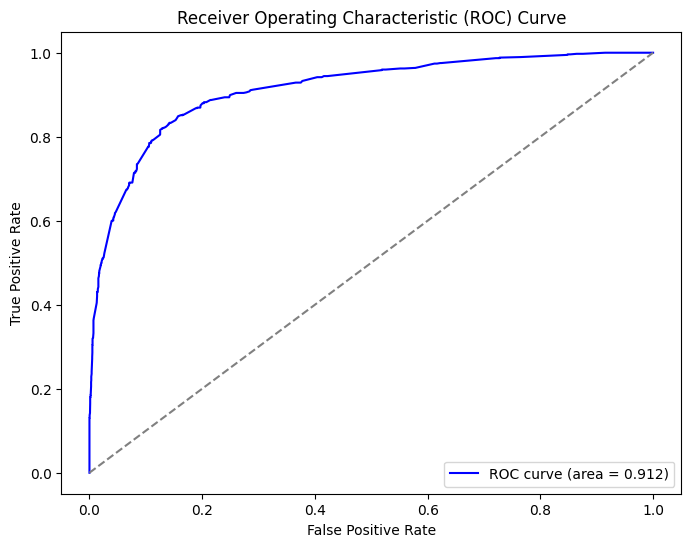

In [72]:
apply_model_and_evaluate(final_model_coefficients_unbalanced, training_df)

ROC-AUC scores are higher than the average recorded in the multiple feature selection. This may not need to be a cause for concern, because the features were applied to the whole training dataset, rather than 80% of the dataset (five-fold cross-validation was used in the feature selection).

## Validation data

### Data transformation

In [73]:
# validation_df

I apply the same transformations from the training data to the validation data.

In [74]:
transform_anomalies(validation_df)
validation_df = drop_irrelevant_columns(validation_df)
validation_df, summary_of_bins_df = create_custom_bins(validation_df)
drop_columns_after_WoE(validation_df)
validation_df = one_hot_encode_bins(validation_df)

# all imported from transform_all_datasets_functions.py

Dropped columns: LTV RATIO, CREDIT LINES, JOB, OUTSTANDING MORTGAGE
Dropped columns: YEARS AT JOB_bin, PROPERTY VALUE, YEARS AT JOB, DEROGATORY REPORTS, DELINQUENT CREDIT LINES, OLDEST CREDIT (MONTHS), RECENT CREDIT ENQUIRIES, DEBTINC


In [75]:
# validation_df[validation_df['PROPERTY VALUE'] < 50000]
# validation_df[validation_df['PROPERTY VALUE_bin'] == -1].head(1)

In [76]:
validation_df.head()

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_2,RECENT CREDIT ENQUIRIES_bin_3,RECENT CREDIT ENQUIRIES_bin_4,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT
idx,,,,,,,,,,,,,,,,,,,,,
328,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1230,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1449,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4659,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4816,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


I use the validation data to see whether the model optimised on my training data performs as well on this dataset. In the appendix, I experimented with balancing my training data so that the model would become better at predicting defaults. However, when I used the coefficients generated by that model, the results were worse than the unbalanced data. I scrapped the balanced training data and moved the calculations to the appendix.

In [77]:
# This was the best performing model applied to my balanced training data. However, it doesn't seem to perform as well on my validation set...
# final_model_coefficients_balanced = get_model_coefficients(training_df_balanced_top_5_models_skl, n_features_index=0, data_source=training_df_balanced, model_type='statsmodels')
# imported from feature_selection_functions.py

### Model selection and results

ROC-AUC: 0.901


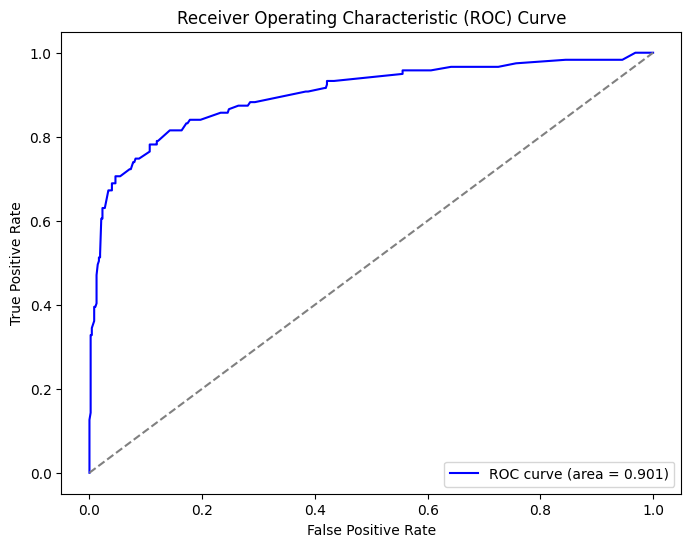

In [78]:
apply_model_and_evaluate(
    final_model_coefficients_unbalanced, validation_df
)  # imported from feature_selection_functions.py

The results on the validation data are similar to those on the training data: the ROC-AUC scores are both above 0.9 (validation = 0.90, training = 0.912).

From the analysis of coefficients, some features have p-values above 0.05, which suggests that they should be removed. These were below 0.05 when run on the training data, so I hesitate to remove them. Also, the coefficients are an order of magnitude smaller than most others, so they are likely to have only a minor impact on the overall log odds of default for each borrower. I therefore decide to keep them in.

## Test data

### Data transformation

I apply the same transformations to the test data.

In [79]:
transform_anomalies(test_df)
test_df = drop_irrelevant_columns(test_df)
test_df, summary_of_bins_df = create_custom_bins(test_df)
drop_columns_after_WoE(test_df)
test_df = one_hot_encode_bins(test_df)

# all imported from transform_all_datasets_functions.py

Dropped columns: LTV RATIO, CREDIT LINES, JOB, OUTSTANDING MORTGAGE
Dropped columns: YEARS AT JOB_bin, PROPERTY VALUE, YEARS AT JOB, DEROGATORY REPORTS, DELINQUENT CREDIT LINES, OLDEST CREDIT (MONTHS), RECENT CREDIT ENQUIRIES, DEBTINC


In [80]:
test_df.head()

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_2,RECENT CREDIT ENQUIRIES_bin_3,RECENT CREDIT ENQUIRIES_bin_4,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT
idx,,,,,,,,,,,,,,,,,,,,,
3030,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
3161,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2453,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
531,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3326,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Model selection and results

ROC-AUC: 0.913


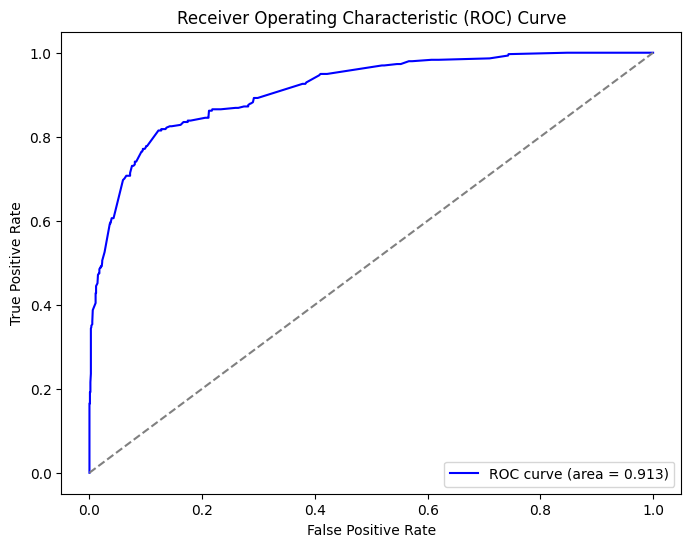

In [81]:
apply_model_and_evaluate(
    final_model_coefficients_unbalanced, test_df
)  # imported from feature_selection_functions.py

The results on the test data are also very similar to those on the training and validation sets: the ROC-AUC score is 0.91 (validation = 0.90, training = 0.91). The model seems to be a strong predictor of credit behaviour and the results are reproducible across all three datasets.

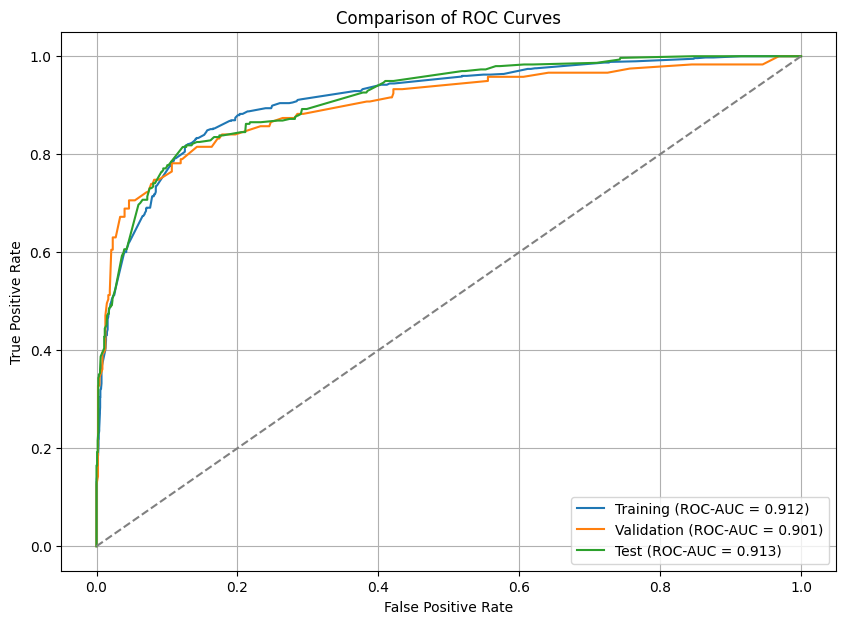

In [82]:
compare_results(
    final_model_coefficients_unbalanced,
    training=training_df,
    validation=validation_df,
    test=test_df,
)

## Analysis of results

I append the predicted probability of default to each row to make it easy to compare the model's estimate with the true outcome (default or non-default).

In [83]:
training_df = add_predicted_probabilities(
    data=training_df, coefficients=final_model_coefficients_unbalanced
)
validation_df = add_predicted_probabilities(
    data=validation_df, coefficients=final_model_coefficients_unbalanced
)
test_df = add_predicted_probabilities(
    data=test_df, coefficients=final_model_coefficients_unbalanced
)

# imported from analysis_of_results_functions.py

In [84]:
# training_df
# validation_df
# test_df

### Dataset merge

I want to assess every borrower, not just those in the test set, so I merge the datasets.

In [85]:
consolidated_pd_df = merge_datasets(
    training_df, validation_df, test_df
)  # imported from analysis_of_results_functions.py


consolidated_pd_df.tail()

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_4,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT,predicted_probability,dataset
idx,,,,,,,,,,,,,,,,,,,,,
4427,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.019,Test
2259,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0.078,Test
135,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.047,Test
2894,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0.987,Test
4075,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.019,Test


### Monotonicity analysis

To check whether my model functions correctly, I run an analysis to check for monotonicity. Each borrower is assigned a group between 1 and 10 (group 1 = the lowest probability of default), and each group is defined either using a cut-off (those with a probability of default between 0 and 0.1 are in group 1, above 0.1 up to 0.2 in group 2, and so on) or a quantile (those up to the 10th percentile are in group 1, and so on).

A well-functioning model should see an increasing number of defaults as the group number increases (a monotonic result), and the default rate within each group should closely match the predicted probability of default. My model (the model applied to each dataset and then merged) is monotonic when borrowers are grouped by cut-off probability, but not monotonic when borrowers are grouped by quantile. In the latter case, the default rate in group 5 is marginally higher than group 6.

This is not ideal, but not enough to invalidate the model. In hindsight, I perhaps should have run the monotonicity analysis on the training data, and then made the appropriate changes to the model.

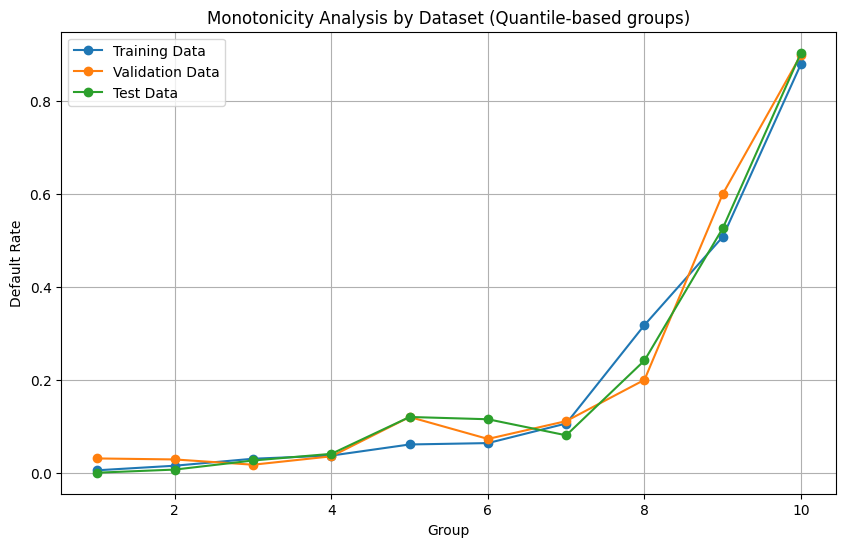

Results for Training dataset:


,defaults,total,average_probability,default_rate,Trend
group,,,,,
1,2,388,0.009,0.005,No Change
2,7,464,0.019,0.015,Increasing
3,10,332,0.027,0.030,Increasing
4,24,650,0.041,0.037,Increasing
5,9,148,0.055,0.061,Increasing
6,22,345,0.070,0.064,Increasing
7,41,387,0.111,0.106,Increasing
8,124,390,0.263,0.318,Increasing
9,196,386,0.534,0.508,Increasing




Results for Validation dataset:


,defaults,total,average_probability,default_rate,Trend
group,,,,,
1,2,65,0.009,0.031,No Change
2,2,70,0.019,0.029,Decreasing
3,1,58,0.029,0.017,Decreasing
4,3,85,0.044,0.035,Increasing
5,3,25,0.055,0.120,Increasing
6,4,55,0.071,0.073,Decreasing
7,7,63,0.103,0.111,Increasing
8,13,65,0.232,0.200,Increasing
9,30,50,0.510,0.600,Increasing




Results for Test dataset:


,defaults,total,average_probability,default_rate,Trend
group,,,,,
1,0,159,0.009,0.000,No Change
2,1,148,0.018,0.007,Increasing
3,4,152,0.025,0.026,Increasing
4,10,246,0.041,0.041,Increasing
5,6,50,0.055,0.120,Increasing
6,16,139,0.071,0.115,Decreasing
7,12,149,0.116,0.081,Decreasing
8,36,149,0.253,0.242,Increasing
9,80,152,0.528,0.526,Increasing


In [86]:
# Note: group_by quartile is not monotonic
monotonicity_analysis(
    consolidated_pd_df, group_by="quantile", analysis_mode="by_dataset"
)  # imported from analysis_of_results_functions.py

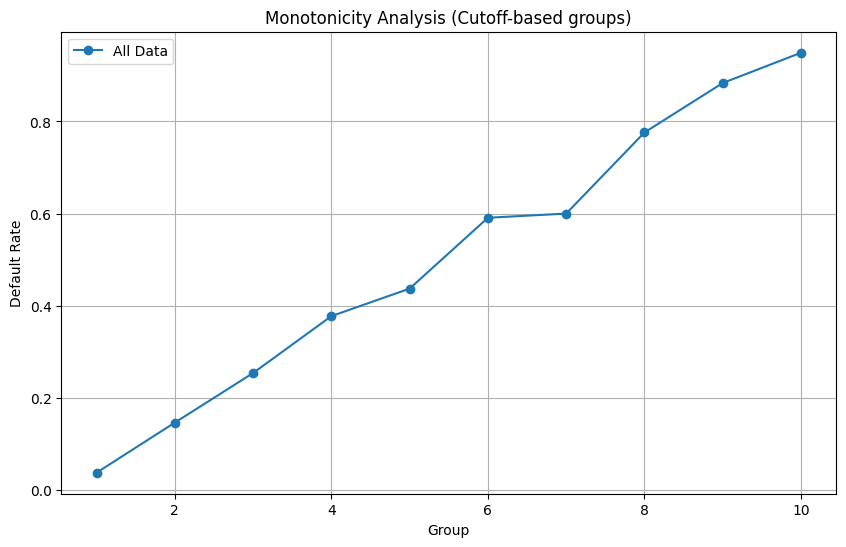

,defaults,total,average_probability,default_rate,Trend
group,,,,,
1,146,3875,0.039,0.038,No Change
2,72,492,0.149,0.146,Increasing
3,48,189,0.245,0.254,Increasing
4,97,257,0.338,0.377,Increasing
5,101,231,0.452,0.437,Increasing
6,130,220,0.561,0.591,Increasing
7,42,70,0.667,0.600,Increasing
8,149,192,0.768,0.776,Increasing
9,106,120,0.855,0.883,Increasing


In [87]:
# Note: group_by quantile is not monotonic
monotonicity_analysis(
    consolidated_pd_df, group_by="cutoff"
)  # imported from analysis_of_results_functions.py

In [88]:
# # Note: group_by quantile is not monotonic
# monotonicity_analysis(
#     consolidated_pd_df, group_by="quantile"
# )  # imported from analysis_of_results_functions.py

In [90]:
consolidated_pd_df.columns

Index(['PROPERTY VALUE_bin_1', 'PROPERTY VALUE_bin_2', 'PROPERTY VALUE_bin_3',
       'PROPERTY VALUE_bin_4', 'PROPERTY VALUE_bin_0',
       'DEROGATORY REPORTS_bin_2', 'DEROGATORY REPORTS_bin_3',
       'DEROGATORY REPORTS_bin_0', 'DELINQUENT CREDIT LINES_bin_2',
       'DELINQUENT CREDIT LINES_bin_3', 'DELINQUENT CREDIT LINES_bin_0',
       'OLDEST CREDIT (MONTHS)_bin_2', 'OLDEST CREDIT (MONTHS)_bin_3',
       'OLDEST CREDIT (MONTHS)_bin_4', 'OLDEST CREDIT (MONTHS)_bin_0',
       'RECENT CREDIT ENQUIRIES_bin_2', 'RECENT CREDIT ENQUIRIES_bin_3',
       'RECENT CREDIT ENQUIRIES_bin_4', 'RECENT CREDIT ENQUIRIES_bin_0',
       'DEBTINC_bin_2', 'DEBTINC_bin_3', 'DEBTINC_bin_4', 'DEBTINC_bin_5',
       'DEBTINC_bin_0', 'DEFAULT', 'predicted_probability', 'dataset',
       'group'],
      dtype='object')

The group associated with each borrower is added to the merged data.

In [37]:
consolidated_pd_df.head(1)

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT,predicted_probability,dataset,group
idx,,,,,,,,,,,,,,,,,,,,,
89,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.567,Training,9


## Export data

In [38]:
folder_path = r"C:\Users\james\OneDrive - University of Aberdeen\01 - Turing College\04 - Specialisation courses\04 - Risk Analyst\Credit risk dataset\datasets"

consolidated_pd_df.to_csv(f"{folder_path}/consolidated_pd_df.csv", index=True)

## Appendix

### Balanced training data

I decided to balance my training data to increase the model's exposure to the minority class ('DEFAULT' = 1). I used undersampling, so that rows of the majority class are removed at random until there is an equal number of rows from the majority and minority class. I then used feature selection to determine the best features and coefficients for the model. The results on the balanced training data were excellent--better than any other model--but these results were not replicated on the validation data, so the model was discarded.  

In [39]:
# training_df_balanced = balance_data_undersampling(
#     training_df
# )  # imported from balance_data_functions.py

In [40]:
# training_df_balanced.shape

I then run a feature selection on the model. I have to use sci-kit learn here because statsmodels is unable to do feature selection on the imbalanced set.

In [41]:
# training_df_balanced_top_5_models_skl = multiple_feature_selection_skl(
#     training_df_balanced, threshold=0.3, top_5="f1"
# )

In [42]:
# training_df_balanced_top_5_models_skl.head(1)

In [43]:
# final_model_coefficients_balanced = get_model_coefficients(
#     training_df_balanced_top_5_models_skl,
#     n_features_index=0,
#     data_source=training_df_balanced,
#     model_type="statsmodels",
# )

In [44]:
# Now apply to validation set
# apply_model_and_evaluate(final_model_coefficients_balanced, training_df_balanced)

The results appear to be excellent (even better than using the coefficients from the unbalanced feature selection). However, these results were not reproduced on the validation dataset.

In [45]:
# This was the best performing model applied to my balanced training data. However, it doesn't seem to perform as well on my validation set...
# final_model_coefficients_balanced = get_model_coefficients(
#     training_df_balanced_top_5_models_skl,
#     n_features_index=0,
#     data_source=training_df_balanced,
#     model_type="statsmodels",
# )

In [46]:
# apply_model_and_evaluate(final_model_coefficients_balanced, validation_df)

As the results above show, F1 score never reaches 0.70, and accuracy is down at 0.8 (well below the 0.87 and 0.88 of the training and validation sets, respectively). This model was therefore discarded before reaching the test data.

### Mlxtend feature selection

Another option for feature selection, aside from the statsmodels and sci-kit learn libraries, is to use the SequentialFeatureSelector from mlxtend. This allows for floating feature selection based on specified scoring metrics, which may give the most flexibility of all feature selection libraries. However, it took over 30 seconds to run each iteration, so was discarded.

In [47]:
# from mlxtend.feature_selection import SequentialFeatureSelector
# from sklearn.linear_model import LogisticRegression
# import pandas as pd
# import warnings

# def perform_feature_selection(df, response_variable='DEFAULT', scoring='roc_auc', k_features=14, model=LogisticRegression()):
#     """
#     Performs feature selection using stepwise (forward) selection for logistic regression.

#     Parameters:
#     - df: pd.DataFrame, The dataset containing features and target variable.
#     - response_variable: str, The name of the target variable (default='DEFAULT').
#     - scoring: str, The scoring metric for evaluation (default='roc_auc').
#     - k_features: int, str or tuple, The number of features to select (default='best').
#       - 'best' for selecting the best number of features automatically,
#       - an integer for selecting a specific number of features,
#       - a tuple (min, max) for selecting a range of features.
#     - model: sklearn model (optional), If provided, this will be used as the model instead of LogisticRegression.

#     Returns:
#     - selected_features: List of selected features based on the feature selection process.
#     - sfs_results: A DataFrame containing detailed metrics for each iteration of the feature selection.
#     """
#     warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.model_selection")
#     pd.set_option('display.float_format', lambda x: '%.2f' % x)

#     # Ensure the response variable and independent variables are correctly defined
#     if response_variable not in df.columns:
#         raise ValueError(f"Response variable '{response_variable}' not found in the DataFrame columns.")

#     independent_variables = [col for col in df.columns if col != response_variable]

#     # Prepare target and feature data
#     y = df[response_variable].values.ravel()  # Flatten y to ensure it's the right shape
#     X = df[independent_variables]

#     # Initialize the SequentialFeatureSelector
#     sfs = SequentialFeatureSelector(model,
#                                     k_features=k_features,  # Can be 'best', an integer, or a tuple
#                                     forward=True,
#                                     floating=False,  # Allow floating stepwise selection
#                                     scoring=scoring,
#                                     verbose=0,
#                                     cv=5)  # Use 5-fold cross-validation

#     # Fit the feature selection model
#     sfs.fit(X, y)

#     # Get the selected features by index and map them to the feature names
#     selected_features = X.columns[list(sfs.k_feature_idx_)]

#     # Get detailed metrics for each step of feature selection
#     sfs_results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

#     sfs_results.reset_index(inplace=True)
#     sfs_results.rename(columns={'index': 'model_id'}, inplace=True)

#     if 'cv_scores' in sfs_results.columns:
#         sfs_results['cv_scores'] = sfs_results['cv_scores'].apply(lambda x: [round(score, 3) for score in x])

#     # # Set pandas option to display full column width for the results
#     # pd.set_option('display.max_colwidth', None)

#     return selected_features, sfs_results

# selected_features, sfs_results = perform_feature_selection(training_df, k_features='parsimonious')

# sfs_results

# # selected_features

### Kolmogorov-Smirnov test

I considered using a Kolmogorov-Smirnov (K-S) test to determine the optimal probability threshold. I would set the cut-off probability where the gap between cumulative distributions of defaults and non-defaults is the highest. However, I opted for a simpler table of probability thresholds to inform my decision.

In [48]:
# from scipy.stats import ks_2samp
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# def ks_test_and_plot(
#     merged_df: pd.DataFrame,
#     default_column: str = 'DEFAULT',
#     predicted_prob_column: str = 'predicted_probability',
#     dataset_column: str = 'dataset',
#     bins: int = 50
# ) -> None:
#     """
#     Perform KS test on defaulters vs non-defaulters and plot the CDFs for each dataset (training, validation, test).

#     Parameters:
#         merged_df (pd.DataFrame): DataFrame containing the target variable, predicted probability, and dataset information.
#         default_column (str): The column name representing defaulters (default is 'DEFAULT').
#         predicted_prob_column (str): The column name representing predicted probabilities (default is 'predicted_probability').
#         dataset_column (str): The column name representing the dataset (default is 'dataset').
#         bins (int): Number of bins to use for the histogram (default is 50).

#     Returns:
#         None
#     """
#     # List of unique datasets (e.g., 'training', 'validation', 'test')
#     datasets = merged_df[dataset_column].unique()

#     # Iterate over each dataset
#     for dataset in datasets:
#         print(f"\nProcessing dataset: {dataset}")

#         # Filter data by the dataset
#         dataset_data = merged_df[merged_df[dataset_column] == dataset]

#         # Split probabilities for defaulters (1) and non-defaulters (0)
#         defaulters = dataset_data[dataset_data[default_column] == 1][predicted_prob_column]
#         non_defaulters = dataset_data[dataset_data[default_column] == 0][predicted_prob_column]

#         # Compute KS statistic and p-value
#         ks_stat, p_value = ks_2samp(defaulters, non_defaulters)

#         # Print KS Statistic and p-value
#         print(f"KS Statistic for {dataset}: {ks_stat:.3f}, p-value: {p_value:.3f}")

#         # Plot the CDFs for the current dataset
#         plt.figure(figsize=(8, 6))
#         plt.hist(defaulters, bins=bins, density=True, cumulative=True, label='Defaulters', histtype='step', color='red')
#         plt.hist(non_defaulters, bins=bins, density=True, cumulative=True, label='Non-Defaulters', histtype='step', color='blue')
#         plt.xlabel('Predicted Probability')
#         plt.ylabel('Cumulative Density')
#         plt.title(f'Cumulative Distribution Function (CDF) for {dataset} (Defaulters vs Non-Defaulters)')
#         plt.legend()
#         plt.grid()
#         plt.show()

In [49]:
# ks_test_and_plot(merged_df)

### Calibration plot

I also considered using a calibration curve to compare the predicted probability of default with actual default rates. This, however, is very similar to the monotonicity analysis, so was excluded from the analysis.

In [50]:
# from sklearn.calibration import calibration_curve
# import matplotlib.pyplot as plt
# import pandas as pd
# from typing import Optional


# def plot_calibration_curve(
#     dataset_df: pd.DataFrame,
#     actual_column: str = "DEFAULT",
#     predicted_column: str = "predicted_probability",
#     n_bins: int = 10,
# ) -> None:
#     """
#     Plot the calibration curve to compare predicted probabilities with actual default rates.

#     Parameters:
#         dataset_df (pd.DataFrame): The dataframe for the specific dataset (e.g., training_df, validation_df, test_df).
#         actual_column (str): The name of the column that contains the actual labels (defaults 1, non-defaults 0).
#         predicted_column (str): The name of the column that contains the predicted probabilities.
#         n_bins (int): Number of bins to group predicted probabilities.

#     Returns:
#         None: Displays the calibration plot.
#     """
#     # Extract actual labels and predicted probabilities from the dataset
#     actual = dataset_df[actual_column]
#     predicted_prob = dataset_df[predicted_column]

#     # Calculate the calibration curve
#     fraction_of_positives, mean_predicted_value = calibration_curve(
#         actual, predicted_prob, n_bins=n_bins
#     )

#     # Plot the calibration curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(
#         mean_predicted_value,
#         fraction_of_positives,
#         marker="o",
#         label="Calibration Curve",
#     )
#     plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
#     plt.xlabel("Mean Predicted Probability")
#     plt.ylabel("Actual Default Rate")
#     plt.title(f"Calibration Curve")  # Name from dataset column if available
#     plt.legend()
#     plt.grid()
#     plt.show()

In [51]:
# plot_calibration_curve(merged_df)

Considerations for next time:
- In my monotonicity analysis, I have some groups with lower default rates than the previous group. How do I know when this is a problem (ie. the model needs changing) and how would you go about changing the model?
- What other methods should I use to analyse my results? (Should I use a population stability index or something else like that?)
- Look up pooled grades/credit scores/credit scorecards
- Work on optimising speed...
- Observed default shouldn't be systematically higher than predicted
- Assign average default rate to each group (and merge group 6 and 7 in the monotonicity analysis)
- Transform bin values to WoE instead of OHE (would solve the lack of monotonicity for some binned features without creating lots of new columns)
- Compare ROC-AUC/Gini of test set and training set directly (in the same chart), rather than indirectly
- Look into discrete time survival when you have a dataset with dates in it.
- Look into tuning hyperparameters.
- Look into discrete time-hazard models (for time series data, so not this dataset).

Questions answered in first review:
- Use of SHAP and Lime for explainable deep learning models. Is this a thing in credit risk or too far in the future?